In [2]:
from Bio import SeqIO
from embeddings_config import avail_models
import numpy as np
import os
import argparse

def get_sequences(fastadir=None, fastafile=None):
    sequences = []
    if fastadir is None and fastafile is None:
        print("No fasta dir or file")
        raise
    if fastadir is not None and fastafile is not None:
        print("Choose one, fasta dir or multi fasta filr")
        raise
    # check for a directory with individual fasta files
    # or a multi fasta file
    if fastadir is not None:
        fastafiles = os.listdir(fastadir)
        for f in fastafiles:
            counter = 0
            for record in SeqIO.parse(os.path.join(fastadir, f), "fasta"):
                sequences.append(record)
                counter += 1
                if counter > 1:
                    print("More than one fasta record?", f)
                    raise
    elif fastafile is not None:
        for record in SeqIO.parse(fastafile, "fasta"):
            sequences.append(record)
    return sequences

sel_embedding = 'halft5'
fastadir=None
fastafile=None
annotdir=None
annotfile=None

# Disprot
fastadir="/data/franco/datasets/disprot/fasta/"
annotfile="/data/franco/datasets/disprot/DisProt_release_2022_06_reformat_annot.fasta"
embeddir="/data/franco/datasets/prot_embedding_weights/disprot/halft5/"

# Monomers
# fastafile="/data/franco/datasets/disprot/monomers.fasta"
# annotfile="/data/franco/datasets/disprot/monomers_annot.fasta"
# embeddir="/data/franco/datasets/prot_embedding_weights/monomers/halft5/"

if sel_embedding not in avail_models:
    print("ERROR: Selected model not available")
    raise

sequences = get_sequences(fastadir=fastadir, fastafile=fastafile)
annots    = get_sequences(fastadir=annotdir, fastafile=annotfile)

In [3]:
# find annotation for each sequence
# read annotation data first
annot_dict = dict()
for record in annots:
    if "|" in record.name:
        name = record.name.split("|")[1].strip()
    else:
        name = record.name.split()[0].strip()
        if name == "":
            print("Name is empty",record.name)
    annot_dict[name] = str(record.seq)

In [ ]:
all_dict = dict()

In [14]:
# dictionary with input sequences, embeddings and disorder annotation
all_dict = dict()
disseqs = list()
embeddings = list()
selected_sequences = list()

# grab one sequence
for i,s in enumerate(sequences):
    if i > 10:
        break
    if "|" in s.name:
        name = s.name.split("|")[1].strip()
    else:
        name = s.name.split()[0].strip()
        if name == "":
            print("Name is empty",s.name)
            raise
    print(f"working on {name}")
    aa_sequence = str(s.seq).upper()
    if len(aa_sequence) > 1200:
        print(f"Skipping {name}, len={len(aa_sequence)}")
        continue
    embed_file = os.path.join(embeddir, name+".gz")
    if os.path.exists(embed_file):
        if len(s.seq) == len(annot_dict[name]):
            # read embedding
            e = np.loadtxt(embed_file)
            # add annot, seq and embedding
            if len(s.seq) == e.shape[0]:
                all_dict[name] = dict()
                all_dict[name]["disorder"] = annot_dict[name]
                all_dict[name]["embedding"]= e
                all_dict[name]["seq"] = aa_sequence
            else:
                print("Embedding length and seq do not match")
                print(e.shape, len(s.seq), name)
        else:
            print("Sequence and annotation length do not match")
            print(len(s.seq), len(annot_dict[name]), name)
    else:
        ## skip this file
        print(f"skipped {embed_file} does not exist")
        continue

working on Q8R426-2
working on Q13740
working on Q9CXW3
working on O75807
working on P02259
working on P08523
working on P77173
working on Q9LQT8
working on P53563
working on Q9BYF1
working on Q920Q2
Skipping Q920Q2, len=1249


In [69]:
all_names = list(all_dict.keys())

uniprot = all_names[0]
disorder = all_dict[uniprot]["disorder"]
Y = np.array([d != "-" for d in disorder], dtype=np.int8)
X = all_dict[uniprot]["embedding"]

In [70]:
print(X.shape, Y.shape)

(216, 1024) (216,)


In [143]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import ElasticNet

# regenet = ElasticNet().fit(X, Y)
# r2_enet = regenet.score(X,Y)

def regress_each_dimension_linear(X,Y):
    reg = LinearRegression()
    myrlist = list()
    mycoef  = list()
    for i in range(X.shape[1]):
        x = X[:,i][:, np.newaxis]
        reg.fit(x, Y)
        myrlist.append(reg.score(x, Y))
        mycoef.append(reg.coef_)
    return myrlist, mycoef

def regress_each_dimension_logistic(X,Y):
    reg = LogisticRegression(penalty='l2')
    myrlist = list()
    mycoef  = list()
    for i in range(X.shape[1]):
        x = X[:,i][:, np.newaxis]
        reg.fit(x, Y)
        myrlist.append(reg.score(x, Y))
        mycoef.append(reg.coef_)
    return myrlist, mycoef


res_linear, coef_lin = regress_each_dimension_linear(X,Y)
res_logist, coef_log = regress_each_dimension_logistic(X,Y)
print(np.mean(res_linear))
print(np.mean(res_logist))

0.010409759511319316
0.9490740740740743


In [122]:
# One coefficient per dimension, one r2 per dimension accross all residues in a protein
print(len(coef_lin), len(coef_log))
print(len(res_linear), len(res_logist))

1024 1024
1024 1024


0.9490740740740741


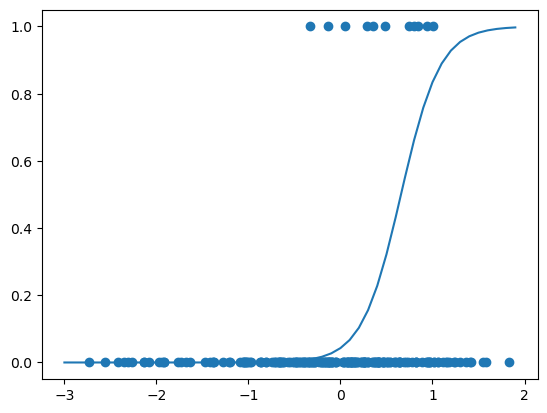

In [159]:
import matplotlib.pyplot as plt

i = 0
x = X[:,i][:, np.newaxis]
reg = LogisticRegression(penalty='none')
reg.fit(x, Y)
print(reg.score(x, Y))

xB = x*reg.coef_
xref = np.arange(-3,2,0.1)
y_line = 1 / ( 1 + np.exp((xref*reg.coef_) - reg.intercept_)[0])
plt.plot(xref, y_line)
plt.scatter(xB, Y)

plt.show()

In [158]:
reg.predict(x)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [123]:
#### Redo but for entire embeddings concatenated

import umap
import numpy as np
import os
import argparse
import time

embedmatfile = "disprot_plotdata17102022/halft5/embedding_data.txt.npz"
# load seq and annotation data
seqfile = "disprot_plotdata17102022/halft5/seq_data.txt"
annfile = "disprot_plotdata17102022/halft5/annot_data.txt"

with open(seqfile) as instr:
    seq = instr.readlines()[0]
    
with open(annfile) as instr:
    annot = instr.readlines()[0]
    
print(len(seq), len(annot))
SEQ = [aa for aa in seq]
ANNOT = [an for an in annot]
AAs = set(SEQ)

903246 903246


In [124]:
s = time.time()
print("Loading embedding..")
loaded_data = np.load(embedmatfile)
embeddings = loaded_data["concat_emb"]
e = time.time() - s
print(f"Loaded in {e}!")

Loading embedding..
Loaded in 62.788193464279175!


In [133]:
Yall = np.array([d != "-" for d in ANNOT], dtype=np.int8)

In [134]:
allres_linear, allcoef_lin = regress_each_dimension_linear(embeddings,Yall)
allres_logist, allcoef_log = regress_each_dimension_logistic(embeddings,Yall)

# class imbalance problem? see below. Linear regression doesn't really work here

0.7797864590598796


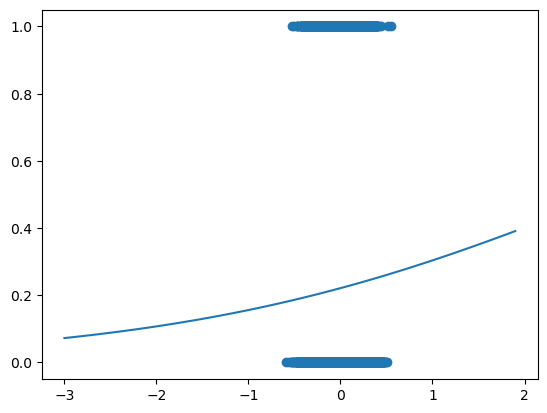

In [162]:
# use only one dimension from above, with all data of course

i = 0
x = embeddings[:,i][:, np.newaxis]
reg = LogisticRegression(penalty='none')
reg.fit(x, Yall)
print(reg.score(x, Yall))

xB = x*reg.coef_
xref = np.arange(-3,2,0.1)
y_line = 1 / ( 1 + np.exp((xref*reg.coef_) - reg.intercept_)[0])
plt.plot(xref, y_line)
plt.scatter(xB, Yall)

plt.show()

## One dimension doesn't work, predictions are always all zero.
## Class imbalance makes it better to predict everything as zero.

In [173]:
# use ALL dimensions from above, with all data of course

X = embeddings
reg = LogisticRegression(penalty='l1', solver='saga', l1_ratio=0.5)
reg.fit(X, Yall)
print(reg.score(X, Yall))

/home/franco/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


0.8270891872203143


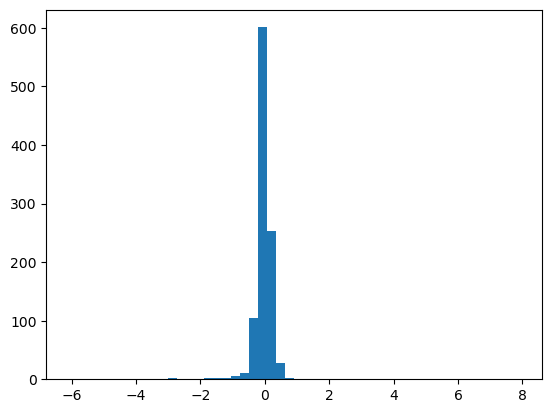

In [181]:
plt.hist(reg.coef_[0], bins=50)
plt.show()
